# Proximity analysis
In this notebook we will be working with data from [OpenStreetMap](https://openstreetmap.org) to do proximity analysis to various urban amenities.

In [34]:
import geopandas
from matplotlib.colors import ListedColormap
import osmnx as ox
import pyproj
from shapely.ops import transform

%matplotlib inline

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.15.1'

## Import data
We import pre-processed data from OpenStreetMap. Rather than working on a whole country or city, we have selected a subset of the city of Tampere. We have also divided the data into three categories: food sources, bus stops, and building footprints.

In [47]:
location = {'city':'San Luis Obispo', 'state':'California'}

location_df = ox.geocode_to_gdf(location)

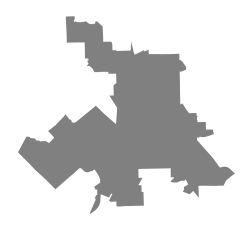

In [49]:
location_proj = ox.project_gdf(location_df)
ax = location_proj.plot(fc='gray', ec='none')
_ = ax.axis('off')

### Food sources

In [59]:
food_sources_tags = {
    "shop": [
        "supermarket",
        "convenience",
        "bakery",
    ]
}

In [60]:
food_sources_df = ox.pois_from_place(location, food_sources_tags)
food_sources_df.shape

(30, 30)

In [61]:
food_sources_df.head()

,osmid,geometry,addr:city,addr:housenumber,addr:street,name,shop,element_type,opening_hours,wheelchair,...,website,entrance,short_name,nodes,addr:street:type,building,layer,car_wash,organic,designation
581314991,581314991,POINT (-120.66858 35.27274),San Luis Obispo,241,Pismo Street,Farb's Bakery,bakery,node,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
611128561,611128561,POINT (-120.67345 35.24499),San Luis Obispo,3977,South Higuera,Trader Joe's,supermarket,node,08:00-20:00,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665502051,665502051,POINT (-120.67353 35.24455),NaN,3985,NaN,Food 4 Less,supermarket,node,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994248733,994248733,POINT (-120.66031 35.29139),NaN,NaN,NaN,7-Eleven,convenience,node,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004789314,2004789314,POINT (-120.67083 35.26937),San Luis Obispo,158E,Higuera Street,SLO Beverage 'n More,convenience,node,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

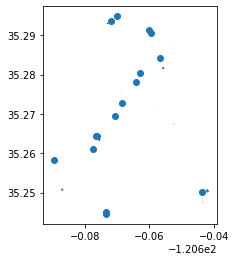

In [67]:
food_sources_df.plot()

### Bus stops

In [66]:
bus_stops_tags = {
    "amenity" : True,
    "highway" : "bus_stop"
}
bus_stops_gdf = ox.pois_from_place(location, bus_stops_tags)
bus_stops_gdf.shape

(1401, 158)

<AxesSubplot:>

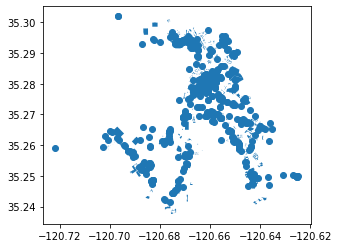

In [68]:
bus_stops_gdf.plot()

### Buildings

In [69]:
buildings_tags = {
    "building": True,
}
buildings_gdf = ox.pois_from_place(location, buildings_tags)
buildings_gdf.shape

(20244, 127)

<AxesSubplot:>

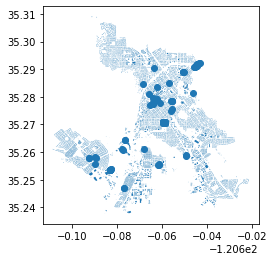

In [70]:
buildings_gdf.plot()

Now we can get counts of each data set, to get an idea of the size.

## Use OSM for GeoDataFrame index
OpenStreetMap provides an identifier for each geometry. So we will use the OSM identifier through our notebook.

In [11]:
buildings.set_index("osm_id", inplace=True, verify_integrity=True)
bus_stops.set_index("osm_id", inplace=True, verify_integrity=True)
food_sources.set_index("osm_id", inplace=True, verify_integrity=True)

## Building centroids
Building geometries have varying numbers of points and lines, or complexity. We can simplify things by reducing each building footprint to the aproximate center, or centroid.

In [12]:
buildings["centroid"] = buildings["geometry"].centroid

In [13]:
buildings.head()

,code,fclass,name,type,geometry,centroid
osm_id,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055)
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709)
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620)
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543)
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104)


Since subsequent steps will work with a column called "geometry", we will swap our complicated footprints with the simple centroids by renaming columns.

In [14]:
buildings.rename(
    columns={
        "geometry": "footprint",
        "centroid": "geometry"
    }, 
    inplace=True
)

In [15]:
buildings.head()

,code,fclass,name,type,footprint,geometry
osm_id,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055)
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709)
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620)
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543)
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104)


Let's just double check that we still have two geometry columns.

In [16]:
buildings.dtypes

code            int64
fclass         object
name           object
type           object
footprint    geometry
geometry     geometry
dtype: object

## Create buffers
Next we will create "convenience" distances around each point in our data sets. Convenience is a hypothetical measure of how far people could reasonably access the amenities. These values are purely hypothetical, in order that we can work out further analysis below.

### Food sources

In [17]:
%%time
buffer_distance_m = 1000

food_sources_buffered = food_sources.buffer(buffer_distance_m)

CPU times: user 25.8 ms, sys: 0 ns, total: 25.8 ms
Wall time: 37 ms


### Bus stops

In [18]:
%%time
buffer_distance_m = 250

bus_stops_buffered = bus_stops.buffer(buffer_distance_m)

CPU times: user 191 ms, sys: 3.48 ms, total: 195 ms
Wall time: 201 ms


## Amenity catchments
Since the buffering step makes many separate and overlapping circles, we will combine the overlapping circles into larger "catchments".

### Food sources

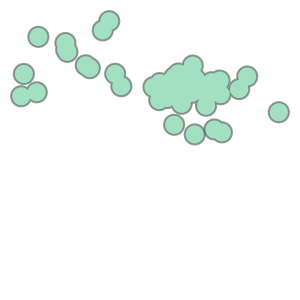

In [19]:
food_sources_catchment = food_sources_buffered.unary_union
food_sources_catchment

### Bus stops

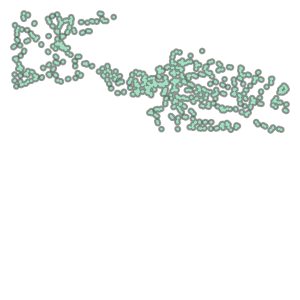

In [20]:
bus_stops_catchment = bus_stops_buffered.unary_union
bus_stops_catchment

## Access to amenities
Now we will combine the food and bus catchments for a composite measure of "access to amenities". We can combine arbitrarily many amenities here, but will start with the two previously mentioned.

CPU times: user 54.7 ms, sys: 0 ns, total: 54.7 ms
Wall time: 55.8 ms


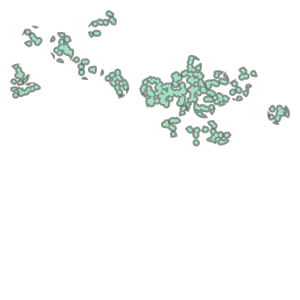

In [21]:
%%time
access_to_amenities = bus_stops_catchment.intersection(food_sources_catchment)
access_to_amenities

## Buildings within food catchment
Now we can search for buildings that are within the various catchments previously calculated.

In [22]:
%%time
buildings["within_food_catchment"] = buildings.within(food_sources_catchment)

CPU times: user 9.74 s, sys: 0 ns, total: 9.74 s
Wall time: 9.74 s


In [23]:
%%time
# Warning, the following is slow, only run if needed
#buildings["within_bus_catchment"] = buildings.within(bus_stops_catchment)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [24]:
%%time
buildings["access_to_amenities"] = buildings.within(access_to_amenities)

CPU times: user 1min 26s, sys: 10.7 ms, total: 1min 26s
Wall time: 1min 26s


In [21]:
buildings.head()

,code,fclass,name,type,footprint,geometry,within_food_catchment,access_to_amenities
osm_id,,,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055),True,True
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709),False,False
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620),True,True
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543),True,True
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104),True,False


### Visual representation
Let's take a look at the catchments to spot any differences.

In [53]:
colormap = ListedColormap(["coral", "forestgreen"])

<AxesSubplot:>

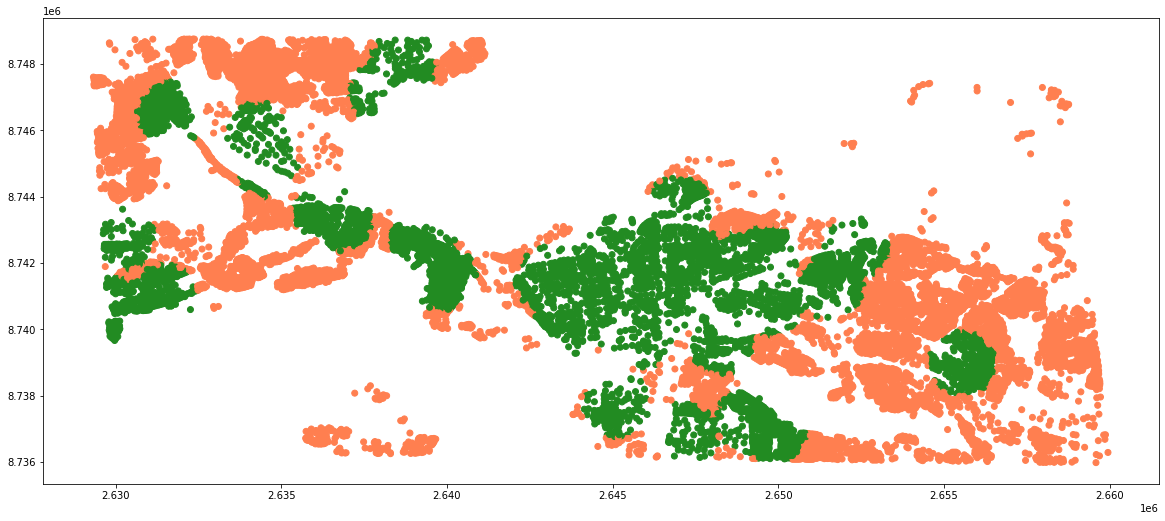

In [54]:
buildings.plot(categorical=True, column="within_food_catchment",figsize=(20, 15), cmap=colormap)

<AxesSubplot:>

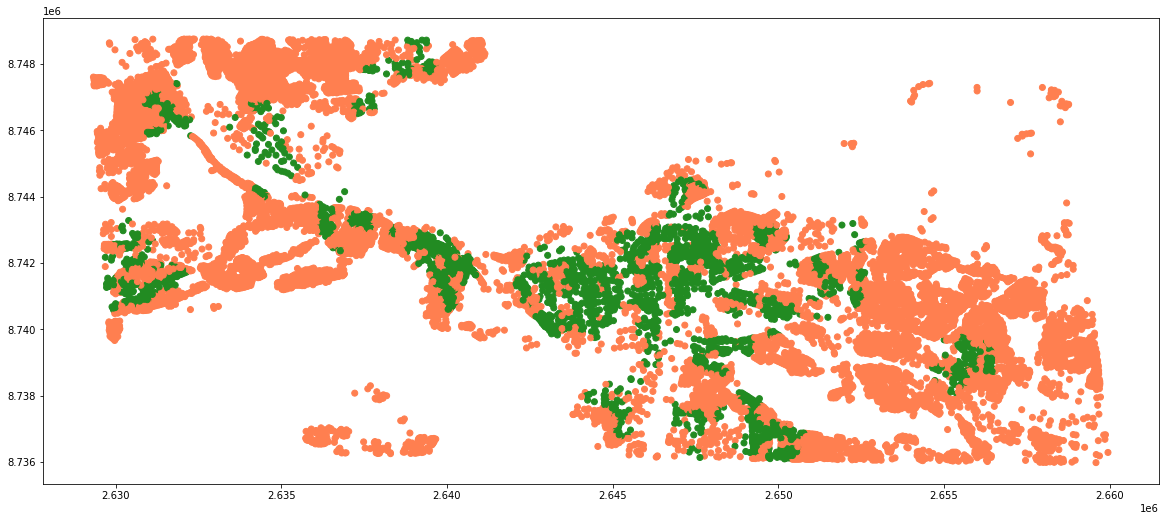

In [55]:
buildings.plot(categorical=True, column="access_to_amenities",figsize=(20, 15), cmap=colormap)

### Proportional representation
We can also calculate the proportion of buildings that meet the convenience criteria. This can be useful for tracking the change over time.

In [56]:
buildings.head()

,code,fclass,name,type,footprint,geometry,within_food_catchment,access_to_amenities,within_bus_catchment
osm_id,,,,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055),True,True,True
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709),False,False,False
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620),True,True,True
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543),True,True,True
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104),True,False,False


In [25]:
buildings["access_to_amenities"].value_counts(normalize=True)

False    0.795716
True     0.204284
Name: access_to_amenities, dtype: float64